# Analyse the historical food prices and nutrient information of the vegetables to help farmers in better decision making

[1. Introduction and Project Background](#intro)

[2. Explored Data Sources](#explored_ds)

[3. Loading Data](#load_begin)

   [3.1 Loading USDA historical prices data](#hp_load)
 
   [3.2 Web scrape the food price index data](#ws_load)
 
   [3.3 Loading and Cleaning the Data from API](#api_load)
 
[4.Analysis of Data ](#4)
 
   [4.1 Nutrients content in the vegetables](#4.1)
 
   [4.2 Plot the nutrient content for each type of vegetable](#4.2)
 
   [4.3 Plot the Production quantity for Escarole & Endive Vegetable](#4.3)
 
   [4.4 Plot the Average Price comparison for Collard Greens vs Kale vs Spinach vs Mustard Greens](#4.4)
 
   [4.5 Plot the Production comparison for Collard Greens vs Kale vs Spinach vs Mustard Greens](#4.5)
 
   [4.6 Plot the Production vs Import vs Average Price of Asparagus](#4.6)
 
   [4.7 Plot the U.S. fresh market vegetables supply utilization](#4.7)
 
   [4.8 Plot the Production vs Import of Cucumber from 1970 to 2017](#4.8)
 
   [4.10 Analyze the Market price, production and imports of Tomatoes](#4.10)
 
   [4.11 Plot the Market prices of vegetables for year](#4.11)
 
   [4.11.1 Market price for vegetables](#4.11.1)
 
   [4.11.2 Deep dive from above plot -Analysis of Asparagus - Why is it consistently costlier](#4.11.1)
  
   [4.12 Total Imports Per Vegetables](#4.12)
 
   [4.13 Plot the Price Index on Total Imports per Vegetable](#4.13)
 
   [4.14 Plot the Price Index of Vegetables when production is greter than Imports](#4.14)
 
   [4.15 Plot the Price Index of Vegetables when Protein content is greter than Sugars](#4.15)

<a id='intro'></a>
## 1. Introduction and Project Background 
This agricultural project provides a study on the yield of Vegetables over the years in the United States. 
The project also provides the crop’s price differentiation over the years and the per capita availability of the produce.
The goal is to provide a comprehensive and easy to use analysis for the farmers to decide on crop production and entice new generation of crop producers.

The reason to take up this project is that we've huge database available for product prices, but it is usually in flat file format which is not readily interpretable and very difficult to visualize and analyse.
At the same time, since this project is taken as an academic study, we wanted to incorporate the diverse sources of data and to be able to combine it and analyse it. So we decided to analyse - imports/exports and historical price data, market price index and nutrient information of the vegetables.

So we aim to take this project as a learning and exploratory data analysis project to uncover interesting trends in US agricultural market by making use of the skills learned in this class.

<a id='explored_ds'></a>
## 2. Explored Data Sources and motivation behind picking them:
We're analysing the following three kinds of data-

#### a. Historical prices and imports/exports data- 
This data is taken from United States department of Agriculture(USDA) website and it is in the flat file format. This is downloaded directly from the USDA website using code. It has total 32 sheets one for each vegetable. It has data related to production, imports/exports, wholesale prices, per capita availability for each veegtable from year 1970 to year 2017. Since so much valuable data is easily available at USDA we decided to make use of this data. We hoped that analysing the historical prices could reveal interesting market trends and help us understand the market dynamics of the agircultural market in USA better. 

#### b. Agricultural Market price index-
Monthly agricultural market price index from year 2014 to 2018 is extracted using webscraping from a price index website. Such market price index data for long term period is usually available in csv format or in downloadable pdfs. But to diversify the scope of this project we decided to webscrape the data from a website. However, this data is available only from the year 2014 to 2018, compared to our historical prices data which is available from 1970 to 2017. So we're limited in the usage of this data for long term price index analysis. Thus, the analysis using this data is done just for the years 2014 to 2017. 

#### c. Nutrient Information of vegetables - 
The Nutrient information is an important aspect which is usually ignored in the decision making by the farmers. Recently we've seen huge demand for healthy foods among people. Most common examples are the increase in production and consumption of Chia seeds, flax seeds, Quinoa, Kale etc. Thus, it is important that farmers are informed of the nutrient information of each vegetable and they can include this information as well in their decision making.  

The data for nutrient information is extracted from and API made available by USDA. The information extracted is for 8 nutrients for each vegetable. The nutrients include - protein, carbohydrates, fats, Glucose Fructose, Sugars, Energy and Fiber. 



In [105]:
# section for imports
import plotly
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
from tabulate import tabulate

The below table summarizes the incoming data, its format, and number of rows and columns and its description for easy understanding.

In [106]:
print(tabulate([['Type', 'FlatFile', 'Website', 'API'],
                ['Incoming format', '32 sheets in one csv', 'HTML Table rows and columns', 'json data'],
                ['# of rows', 965, 49, 150 ], ['# of columns', 10, 2, 9],
               ['Data description', 'Import/export, prices and production',
                'Months with year and Price index', '8 nutrients for each vegetable']], 
               headers=['Info', 'Historical Price Data', 'Price Index Data', 'Nutrient Info'], tablefmt='orgtbl'))

| Info             | Historical Price Data                | Price Index Data                 | Nutrient Info                  |
|------------------+--------------------------------------+----------------------------------+--------------------------------|
| Type             | FlatFile                             | Website                          | API                            |
| Incoming format  | 32 sheets in one csv                 | HTML Table rows and columns      | json data                      |
| # of rows        | 965                                  | 49                               | 150                            |
| # of columns     | 10                                   | 2                                | 9                              |
| Data description | Import/export, prices and production | Months with year and Price index | 8 nutrients for each vegetable |


<a id='load_begin'></a> 
##  3. Data Load and Cleaning

<a id='hp_load'></a>
   ## 3.1 Read Fresh Vegetables data from USDA website into csv and then load into data frame

#### Data load- 
The data is downloaded directly from USDA website and all the cleaning and processing of the data is done through Python code.
##### Step 1 -  Download data
Download the data from USDA website.
##### Step 2 -  Take data from each sheet
The data is in 32 sheets.The first and last sheet are not included in analysis since it has summary data which we're not analysing as part of this project. It was difficult to open each sheet and load it by the individual because it was not feasible and increased the lines of code as well. So it was decided to load the sheets using its sheet number. pandas read_excel provides this functionality. By looping through each sheet number, now the data can be extracted easily. This also makes the code reusable since this code can be used to load other flat files without worrying about the sheet names.
##### Step 3 - Select only 9 columns
Select only that data which has 9 columns. One of the challenges of picking the data from such sources is that the data format is not consistent. Most of the data for vegetables was coming in 9 columns. But some of the vegetables had additional columns and these additional columns were not at the end, rather at column number 5 or column 6. This was making data loading part very difficult. After lot of trials, it was decided to get only those vegetables which have 9 columns because merging 30 sheets, all in different format was unmanageable.

##### Step 4 - Extract vegetable  name
Extract name of the vegetable. Since download of vegetable data is automated and being merged into single dataframe, so vegetable name is extracted and added as a column in dataframe.

##### Step 5 - Remove extra rows
USDA come with lot of additional rows in the beginning and in the end. This data when loaded directly into the dataframe was creating issues, since it has lot of null and non-numeric values were coming in the numeric columns. Also not all vegetables had data for all the years between 1971 and 2017. So we have to make sure that we extract only those rows which are had prices data. 
To overcome this problem, only the rows between the row 4 and the row for year 2017 data is extracted. 

##### Step 6 : Load the data in dataframe
Load the total produce information into a separate dataframe. This is the first sheet of the downloaded csv. Since this has total information for vegetables categore, hence it cannot be concatenated with the individual vegetables dataframe.

In [107]:
# download csv from USDA website
url = 'https://www.ers.usda.gov/webdocs/DataFiles/54529/SandU%20Fresh.xlsx?v=43189'
r = requests.get(url)
with open("fresh.csv",'wb') as f:
    f.write(r.content)

In [108]:
# Load fresh.csv into dataframe
# fresh.csv has 32 sheets for 32 vegetables. Hence loading all the the sheets into one single dataframe
column_names = ['Vegetable','Year','Production','Imports','Supply','Exports',
                'Domestic_Availability','Per_Capita_Availability','Current_Dollars','Constant_2009_Dollars']
fresh_df = pd.DataFrame(columns=column_names)
for i in range(1,31):
#     temp_df= pd.read_excel("fresh.csv", sheetname=i) # use this if pandas version is old. So it doesn't accept sheet_name
    temp_df= pd.read_excel("fresh.csv", sheet_name=i)
    if temp_df.shape[1] == 9: # to remove those sheets which have more than 9 columns
        # Get the vegetable name and insert as the first column of the dataframe
        col1 =temp_df.columns[0]
        beg_pos = 15
        end_pos = col1.find(':')
        veg_name = col1[beg_pos:end_pos]
        veg_name = veg_name.replace(', all uses','')
        veg_name = veg_name.replace('fresh ','')
        temp_df.insert(loc=0, column='Vegetable', value=veg_name) 
        
        # rename the columns 
        temp_df.columns = column_names
        # extract the row number till year 2017 data to remove extra rows at the end
        last_row_idx_str = temp_df[temp_df['Year'].str.contains('2016/17', na=False )].index
        last_row_idx = temp_df[temp_df['Year'] ==  2017].index
        
        # concatenate the DF
        if len(last_row_idx_str) > 0: 
            fresh_df = pd.concat([fresh_df,temp_df.iloc[4:last_row_idx_str[0]+1]], 
                             ignore_index  = True) 
        elif len(last_row_idx) > 0:
            fresh_df = pd.concat([fresh_df,temp_df.iloc[4:last_row_idx[0]+1]], 
                             ignore_index  = True) 

The above read_excel command was not working for pandas 0.20.3 version. However, it is working fine on pandas 0.22.0 so kept the command as it is. 
If the command pd.read_excel("fresh.csv", sheet_name=i) errors out then temp_df= pd.read_excel("fresh.csv", sheetname=i) will work (there is a difference in the attribute name - sheet_name <---> sheetname). 

In [109]:
# replace the invalid values with zero
fresh_df = fresh_df.replace('            --', 0)
fresh_df = fresh_df.replace('             --', 0)

In [110]:
# Load first sheet of csv to get the total produce information
column_names2 = ['Year','Production','Imports','Beginning Stocks','Total_Supply','Exports','Ending_Stocks', 'Shrink_and_Loss',
                'Domestic_Availability','Per_Capita_Availability','Availability_Imported', 'Supply_Exported','Total_US_Population']
total_fresh_df = pd.DataFrame(columns=column_names2)
total_temp_df= pd.read_excel("fresh.csv", sheet_name=0)

# rename the columns 
total_temp_df.columns = column_names2
last_row_idx = total_temp_df[total_temp_df['Year'] ==  2017].index
if len(last_row_idx) > 0:
    total_fresh_df = pd.concat([total_fresh_df,total_temp_df.iloc[5:last_row_idx[0]+1]], 
                     ignore_index  = True)

### Create the Excel File
The final file will be created with the name final_group12.xlsx in the local folder. It has all the raw, clean and merged data.
The fresh.csv which is the raw file for historical prices is not being loaded into the final_group12 excel. It has total of 32 sheets, containing food prices for total 32 vegetables. Since this excel itself had so many sheets, so it is separately downloaded from the link and stored in the local system (this part is handled in the following code).
The cleaned version of fresh.csv is Veg_fresh_clean which is being added in the final excel.

In [111]:
# Code for the Cover sheet of the final file
sheet_name_list = ['Total_fresh_raw','Total_fresh_clean','fresh.csv','Veg_fresh_clean',
    'Price_idx_raw','Price_idx_clean','Nutrient_raw','Nutrient_clean','Final_merged']
description_list = ['This is the raw file  containing summary price information for all the vegetables, taken from USDA website.',
                    'This is the clean file  of Total_fresh_raw. It contains summary price information for all the vegetables. ',
                    'This is the raw file containing price information for fresh vegetables, taken from USDA website. Tt is not provided as a sheet in this excel and will be downloaded in the current working folder.',
                    'All the sheets from fresh.csv for all the vegetables is combined into single dataframe, removing extra data.',
                    'This sheet is the html of the web page scrapped',
                    'This sheet is the dataframe created after scraping the price index data from the page',
                    'Nutrient information taken from USDA API for vegetables in json format',
                    'Dataframe created for all the nutrient information for veggies ',
                    'The data from Veggies_fresh_clean, Price_idx_clean and Nutrient_Clean is merged into single dataframe. Since the Total_fresh_clean is aggregated information for all vegetables so it is not merged into this final dataframe']
first_sheet_df = pd.DataFrame(
    {'Sheet_name': sheet_name_list,
     'Description': description_list}, columns=['Sheet_name', 'Description'])

In [112]:
# Write the Cover sheet, total_fresh dataframe - both raw and clean, fresh_df clean data to excel file
writer = pd.ExcelWriter('final_group12.xlsx', engine='xlsxwriter')
first_sheet_df.to_excel(writer, sheet_name='Cover', index=False)
total_temp_df.to_excel(writer, sheet_name='Total_fresh_raw', index=False)
total_fresh_df.to_excel(writer, sheet_name='Total_fresh_clean', index=False)
fresh_df.to_excel(writer, sheet_name='Veg_fresh_clean', index=False)

<a id='ws_load'></a>
### 3.2 Web scrape the food price index data

The next task is to get the webscraped data for the food price index. 

#### Challenge- 
Most of the sites either had agricultural price index data either in csv or pdf format. Or most of the websites only had price index for last 6 months. Since this was a very short duration to the data analysis, so we had to find a source where we can get long term market price index data. Finally, a source was identified, but it only has 5 years of data from 2014 to 2018. 

Also, this source provides the monthly data and the historical price data was at yearly level.

#### Solution- 
It was decided to web scrape this data, and do market index price comparison and analysis for only those 4 years. The price index for each year was averaged to get the yearly price index.


#### Web scraping process:
The webscraping for this data was not very complicated. The following process was done - 
##### Step 1 - Extract page content using BeautifulSoup
Using BeautifulSoup, the HTML contents of the page were scrapped.

##### Step 2 - Extract the relevant divs.

##### Step 3 - Get the table rows and columns-
The table rows were extracted and stripped off of any special characters. 

##### Step 4 : 
Extract the year from the Months column and create a separate column for year. This is necessary step to aggreagte at year level in the further steps.

In [113]:
page = requests.get('https://ycharts.com/indicators/agriculture_index_world_bank')
page = page.content
soup = bs(page, 'html.parser')
# write html contents to file
# ws_contents_df = pd.DataFrame(list(str(soup.contents)))
# ws_contents_df.to_excel(writer, sheet_name='Price_idx_raw', index=False)
dataTableBox = soup.find('div', {"id": "dataTableBox"})
col1 = []
col2 = []
# get the data from table into lists
for tr in dataTableBox.find_all('tr')[2:]:
    cols = tr.find_all('td')
    if(len(cols) == 0 ): # for empty div comming in between
        continue
#     print(datetime.strptime(cols[0].text, '%m. %d, %y'))
    col1.append(cols[0].text)
    col2.append(float(cols[1].text.strip()))

# Create dataframe from the lists of data
pd1_input_list = {'Month':col1,'Price_Index':col2}
df1 = pd.DataFrame(pd1_input_list)
# Get the year in separate column and get the average price_indices foe each year
df1['Year'] = df1.Month.str.slice(-4)
# Write the dataframe data to excel file
df1.to_excel(writer, sheet_name='Price_idx_clean', index=False)


<a id='api_load'></a>
### 3.3 Loading and Cleaning the Data from API:

The nutrient information for the vegetables is extracted from the API. The main idea to include this data was to increase the diversity in the data sources included in the project. However, it was very difficult to find an API for for price related information. So we decided to fetch the food nutrient related information from USDA website.

#### Challenges in implementing API - 

##### a. No develop support for this API-
This website to get the data through the USDA API is recently launched, so the developer support is very limited and there is not much online help regarding the instructions to get this data. Since both the team members had not worked on APIs before so it was challenging task to figure out the process of extracting the relevant information from API.

##### b. No information of the vegetable and nutrient codes -
The USDA website provides just some toy example with a couple of food items on how to extract the data via API. However it has nutrient information for more that 50,000 items, which include all categories like dairy, fruits, vegetables, cereals, canned items, poultry, beef, etc. And around nutrient information of more than 50 nutrients is provided. But it doesn't specify the codes for vegetables and nutrients. So we had to figure out the codes for every combination of relevant nutrients  and vegetables.

##### c. Multiple versions for same vegetable - 
For the same vegetable, multiple versions of it are available and they have different nutrients. For example, for Brocolli itself, it provided following 6 version -
Broccoli raab, raw
Broccoli raab, cooked
Broccoli, cooked, boiled, drained, without salt	
Broccoli, cooked, boiled, drained, with salt
Broccoli, frozen, chopped, unprepared
Broccoli, raw

This much complexity makes it very difficult to get the specific nutrients from the incoming API data.

##### d. Incoming json format- 
The incoming json format was very complicated so it took lot of efforts to extract the relevant informationn for our analysis.
The json data was in structure dict -> dict -> list -> dict. So for every vegetable, it had a list of nutrients. And information for each nutrient was in a dictionary format. 

The json data when extracted directly into pandas Dataframe looked like this - 

name	                                                                nutrients	                                         
Alfalfa seeds, sprouted, raw	                                        [{'nutrient_id': '211', 'nutrient': 'Glucose (...	
artichoke, medium	Artichokes, (globe or french), cooked, boiled,...	[{'nutrient_id': '211', 'nutrient': 'Glucose (...	
artichoke, medium	Artichokes, (globe or french), cooked, boiled,...	[{'nutrient_id': '211', 'nutrient': 'Glucose (...	

Hence it took lot of efforts to get the data in the correct format.

### Steps to download the API data -
##### Step 1 - Request the API data
API data was extracted using requests.get() method
##### Step 2 - Get the nutrients info in a list
This is done to extract the data from the complex dict -> dict -> list -> dict structure to a simple list structure.
Then a dictionary is created with all the nutrient names and their nutrient contents.

##### Step 3 - Create the data frame
The Data Frame is created which has all the vegetables and thier nutrient information.


In [114]:
import requests
import sys
import json

key = 'GlanxFCOEPxiiEXJK37dPGQjnfM0wFfrZf2uuWti'
url = 'https://api.nal.usda.gov/ndb/nutrients/?format=json&api_key=GlanxFCOEPxiiEXJK37dPGQjnfM0wFfrZf2uuWti&nutrients=208&nutrients=203&nutrients=204&nutrients=205&nutrients=291&nutrients=269&nutrients=211&nutrients=212&fg=1100'
response = requests.get(url)
x = response.json()

json_df =  pd.DataFrame(x)
json_df.to_excel(writer, sheet_name='Nutrient_raw', index=False)
# grab the nutrient information and vegetable name information from nested dict structure from json
my_data = x['report']['foods']
nut_info = [nut for veggie in my_data for nut in veggie['nutrients']] # list of nutrient info
veg = [veggie['name'] for veggie in my_data for nut in veggie['nutrients']] # list of vegetable names - each name is repeated 8 times fro 8 nutrients

#Create dictionary to get just the nutrient value in 'gm' 
gm_dict = {}
gm_dict = defaultdict(list)
for item in nut_info:
    gm_dict['gm'].append(item['gm'])
# create the data frame of the nutrient info - each nutrient values is in each row
nutrients_df_raw = pd.DataFrame(gm_dict)
# get the nutrients in a column format by reshaping the dataframe - total 8 nutrients, so 8 columns are created
nutrients_df_raw = pd.DataFrame(np.reshape(nutrients_df_raw.values,(150,8)), 
                    columns=['Glucose','Fructose','Protein','Sugars','fat',
                             'Carbohydrate' , 'Energy', 'Fiber'])
nutrients_df_raw['Veg_full_name'] = veg[0::8] # since each name is repeated 8 times, so grab every eighth name

nutrients_df_raw.to_excel(writer, sheet_name='Nutrient_clean', index=False)

### Join Fresh DF and Price index dataframe

Merge the fresh_df, which has the historical price info, with the market price index dataframe. The joining column is year. 
The join is done left join to preserve the historical data from year 1971 to 2013. Since the data for these years is not present in the market price index dataframe.

In [115]:
pi_by_year = df1.groupby('Year', as_index=False)['Price_Index'].mean() 
pi_by_year['Year'] = pi_by_year['Year'].astype(int) # convert year to int type
# merge fresh_df and pi_by_year on Year column values
final_df = pd.merge(fresh_df, pi_by_year, on="Year",how='left')


### Find the common vegetables in Nutrient DF and Final DF and then merge the two DF 

Next the nutrient information data frame is merged to create the final merged data frame. The merge is done using the Vegetable name.

Here however the challenge was that since for each vegetable, it had more than 8-9 versions for which different nutrients info was provided. So it was decided to take the nutrient information which was for the raw version of the vegetable.
Also, not all vegetables followed the same naming convention.That is, for some vegetables, there was name didn't included the string 'raw'. For example for Lettuce it had two versions, Lettuce Red and Lettuce Green. So for such vegetables, the nutrient information was extracted separately.



In [116]:
raw_names_nut = [ item for item in nutrients_df_raw['Veg_full_name'] if item.find('raw') > 0]
# find nutrient information for all the vegetables that are present in the fresh vegetables DF
nutrients_df_raw['Vegetable'] = ''
for veg in final_df['Vegetable'].unique():
    veggie = veg + ', raw'
    raw_veggie = [rnn for rnn in raw_names_nut if veggie.lower() in rnn.lower()]
    if len(raw_veggie) > 0:
        true_idx = nutrients_df_raw['Veg_full_name'] == raw_veggie[0]
        nutrients_df_raw['Vegetable'][true_idx] = veg
# Merge nutrients dataframe and Final DF
final_df = pd.merge(final_df, nutrients_df_raw, on="Vegetable", how = 'left')

# Write the dataframe data to excel file
final_df.to_excel(writer, sheet_name='Final_merged', index= False)
writer.save()

<a id='4'></a>
## 4. Analysis of Data

<a id='4.1'></a>
#### 4.1  Nutrients content in the vegetables

In [117]:
nutri_df = nutrients_df_raw[nutrients_df_raw.Vegetable != '']
nutri_df

,Glucose,Fructose,Protein,Sugars,fat,Carbohydrate,Energy,Fiber,Veg_full_name,Vegetable
5,0.65,1,2.2,1.88,0.12,3.88,20,2.1,"Asparagus, raw",asparagus
18,0.49,0.68,2.82,1.7,0.37,6.64,34,2.6,"Broccoli, raw",broccoli
33,0.59,0.55,0.93,4.74,0.24,9.58,41,2.8,"Carrots, raw",carrots
36,0.94,0.97,1.92,1.91,0.28,4.97,25,2,"Cauliflower, raw",cauliflower
39,0.4,0.37,0.69,1.34,0.17,2.97,14,1.6,"Celery, raw",celery
66,1.58,1.54,0.98,3.53,0.18,5.88,25,3,"Eggplant, raw",eggplant
72,0.4,0.41,2.92,0.99,1.49,4.42,35,4.1,"Kale, raw",kale


In [118]:
fresh_df = fresh_df.replace('            --', 0)
fresh_df = fresh_df.replace('             --', 0)

<a id='4.2'></a>
#### 4.2 Plot the nutrient content for each type of vegetable

In [119]:
#######################################################################################
# Install Plotly using Conda install command: conda install plotly
# source: https://plot.ly/~notebook_demo/85/new-to-plotly-plotlys-python-library-i/
#################################################################################
import plotly.plotly as py
from plotly.graph_objs import *

##############################################################################################################################
# When using plotly.offline.iplot to plot offline in Jupyter Notebooks, there is an additional initialization step of running 
# at the start of each notebook session. :
#        plotly.offline.init_notebook_mode(connected=True)
##############################################################################################################################

plotly.offline.init_notebook_mode(connected=True)

trace1 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Glucose'],
    name='Glucose',
    marker=dict(color='#F39C12')
)

trace2 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Fructose'],
    name='Fructose',
    marker=dict(color='#A2D5F2'),
    visible=False
)

trace3 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Protein'],
    name='Protein',
    marker=dict(color='#BB8FCE'),
    visible=False
)

trace4 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Sugars'],
    marker=dict(color='#5499C7'),
    name='Sugars',
    visible=False
)

trace5 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['fat'],
    marker=dict(color='#F1948A'),
    name='Fat',
    visible=False
)

trace6 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Carbohydrate'],
    marker=dict(color='#F4D03F'),
    name='Carbohydrate',
    visible=False
)

trace7 = Bar(
    x=nutri_df['Vegetable'],
    y=nutri_df['Fiber'],
    marker=dict(color='#7DCEA0'),
    name='Fiber',
    visible=False
)

data = Data([trace1, trace2, trace3, trace4, trace5, trace6, trace7])
layout = Layout(
    updatemenus=list([
        dict(
            x=-0.05,
            y=0.8,
            buttons=list([
                dict(
                    args=['marker.color', 'red'],
                    label='red',
                    method='restyle'
                ),
                dict(
                    args=['marker.color', 'blue'],
                    label='blue',
                    method='restyle'
                ),
                dict(
                    args=['marker.color', 'green'],
                    label='green',
                    method='restyle'
                )
            ]),
            yanchor='top'
        ),
        dict(
            x=-0.05,
            y=1,
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False, False]],
                    label='Glucose',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False, False]],
                    label='Fructose',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False, False]],
                    label='Protein',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False, False]],
                    label='Sugars',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False, False]],
                    label='Fat',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True, False]],
                    label='Carbohydrate',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, True]],
                    label='Fiber',
                    method='restyle'
                )
            ]),
            yanchor='top'
        )
    ]),
)
fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

Each Vegetable is a great source of nutrients such as Glucose, Fructose, Protein, Sugars, fat, Carbohydrate, Fiber etc.
In the above plot, by Selecting type of nutrient from the drop down box, selected nutrient content for each type of vegetable will be displayed in the bar diagram.

<a id='4.3'></a>
#### 4.3  Plot the Production quantity for Escarole & Endive Vegetable

In [120]:
import plotly.plotly as ply
import plotly.graph_objs as go 
import plotly.offline as offline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout

plotly.offline.init_notebook_mode(connected=True)

year_ee = fresh_df.iloc[396:443]['Year'] # escarole & endive
prod_ee = fresh_df.iloc[396:443]['Production'] # escarole & endive

plotly.offline.iplot({
    "data": [Scatter(x=year_ee, y=prod_ee)],
    "layout": Layout(title="Production for Escarole & Endive since 1970 (in Million Pounds)")
})

As can be seen from above scatter plots, Escarole & Endive is one vegetable which looks like moving toward extinction since the Production in 2017 (10.6) has reduced to less than 10% of the production that was in 1970 (120). 
Infact, the total Domestic Availibility has reduced from 114.1 in 1970 to 13.3 in 2017.

<a id='4.4'></a>
#### 4.4  Plot the Average Price comparison for Collard Greens vs Kale vs Spinach vs Mustard Greens

In [121]:
import plotly.plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

year_co = fresh_df.iloc[282:302]['Year'] # collard greens
dollr_co = fresh_df.iloc[282:302]['Constant_2009_Dollars'] # collard greens
dollr_ka = fresh_df.iloc[522:542]['Constant_2009_Dollars'] # kale
dollr_mg = fresh_df.iloc[588:608]['Constant_2009_Dollars'] # mustard greens
dollr_sp = fresh_df.iloc[749:796]['Constant_2009_Dollars'] # spinach

plotly.offline.iplot({
    "data": [
        Scatter(x=year_co, y=dollr_co, name ='Collard Greens'), 
        Scatter(x=year_co, y=dollr_ka, name ='Kale'),
        Scatter(x=year_co, y=dollr_mg, name ='Spinach'),
        Scatter(x=year_co, y=dollr_sp, name ='Mustard Greens'),
    ],
    "layout": Layout(title="Average Price comparison for Collard Greens vs Kale vs Spinach vs Mustard Greens", showlegend=True
   )})

The above plot depicts few of the most in demand leafy vegetables for healthier diet. On comparing there average price index, it shows that although the prices has been fluctuating over the years for all the leafy vegetables, but they have reached closer in their average price in 2017.

Collard Greens has seen sharp increase in price in 2016 and tremendous decline in 2017. The reason for the spike in Collard Greens price in 2016 can be referred to the sharp decline in production as can be seen in below plot.

<a id='4.5'></a>
#### 4.5  Plot the Production comparison for Collard Greens vs Kale vs Spinach vs Mustard Greens

In [122]:
plotly.offline.init_notebook_mode(connected=True)

year_co = fresh_df.iloc[282:302]['Year'] # collard greens
prod_co = fresh_df.iloc[282:302]['Production'] # collard greens
prod_ka = fresh_df.iloc[522:542]['Production'] # Kale
prod_mg = fresh_df.iloc[588:608]['Production'] # mustard greens
prod_sp = fresh_df.iloc[749:796]['Production'] # spinach

plotly.offline.iplot({
    "data": [
        Scatter(x=year_co, y=prod_co, name ='Collard Greens'), 
        Scatter(x=year_co, y=prod_ka, name ='Kale'),
        Scatter(x=year_co, y=prod_sp, name ='Spinach'),
        Scatter(x=year_co, y=prod_mg, name ='Mustard Greens')
   ],
    "layout": Layout(
        title="Production Comparison (in million pounds) - Collard Greens vs Kale vs Spinach vs Mustard Greens",
        showlegend=True
   )})

 The above plot is showing the production quantity comparison of the 4 leafy vegetables. Kale and Spinach has seen increased demand in last few years and hence the production has also increased.

<a id='4.6'></a>
#### 4.6  Plot the Production vs Import vs Average Price of Asparagus

In [123]:
plotly.offline.init_notebook_mode(connected=True)

year_as = fresh_df.iloc[47:94]['Year'] # asparagus
dollr_as = fresh_df.iloc[47:94]['Constant_2009_Dollars'] # asparagus
prod_as = fresh_df.iloc[47:94]['Production'] # asparagus
import_as = fresh_df.iloc[47:94]['Imports'] # asparagus

trace_prod = Bar(x=year_as,
                  y=prod_as,
                  name='Production',
                  marker=dict(color='#F1948A'))

trace_import = Bar(x=year_as,
                y=import_as,
                name='Imports',
                marker=dict(color='#A2D5F2'))

trace_dollar = Bar(x=year_as,
                y=dollr_as,
                name='Dollar',
                marker=dict(color='#59606D'))

data = [trace_prod, trace_import, trace_dollar]
layout = Layout(title="Production vs Import vs Average Price of Asparagus",
                xaxis=dict(title='Asparagus'),
                yaxis=dict(title='Quantity (in million pounds)'))
fig = Figure(data=data, layout=layout)

plotly.offline.iplot(fig, filename='jupyter/styled_bar')

As the consumers are moving towards healthier diets, asparagus is one of the key part of it. But since the last decade, with some of the biggest draught in California, one of the country's centre of asparagus farming, domestic production has took a hit.

There has been an a significant increase in the import of asparagus since 2005, much of which comes from Latin America, hereby keeping the price consistent and without much fluctuations.

source:https://www.huffingtonpost.com/2015/04/10/asparagus-farms-california_n_7029836.html

<a id='4.7'></a>
#### 4.7 Plot the U.S. fresh market vegetables supply utilization

In [124]:
###########################################################################################
# https://plot.ly/~notebook_demo/85/new-to-plotly-plotlys-python-library-i/
###########################################################################################
import plotly.plotly as py
from plotly.graph_objs import *
plotly.offline.init_notebook_mode(connected=True)

years = total_fresh_df.iloc[0:]['Year']
prod = total_fresh_df.iloc[0:]['Production']
imprt = total_fresh_df.iloc[0:]['Imports']
perCap = total_fresh_df.iloc[0:]['Per_Capita_Availability']
exports = total_fresh_df.iloc[0:]['Exports']

trace1 = Scatter(
    x=years, y=prod,
    line=Line(
        color='#FFD700',
        width=3
    ),
    name='Production'
)

trace2 = Scatter(
    x=years, y=imprt,
    line=Line(
        color='#D0312D',
        width=3
    ),
    name='Imports'
)

trace3 = Scatter(
    x=years, y=exports,
    line=Line(
        color='#0E4C92',
        width=3
    ),
    name='Exports'
)

trace4 = Scatter(
    x=years, y=perCap,
    line=Line(
        color='#000000',
        width=3
    ),
    name='Per Capita Availability'
)

data = Data([trace1, trace2, trace3, trace4])
layout = Layout(
    title='U.S. fresh market vegetables supply utilization',
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, True, True, True]],
                    label='All',
                    method='restyle'
                ),
                dict(
                    args=['visible', [True, False, False, False]],
                    label='Production',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False]],
                    label='Imports',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False]],
                    label='Exports',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True]],
                    label='Per Capita Availability',
                    method='restyle'
                )
            ]),
        )
    ]),
)
fig = Figure(data=data, layout=layout)
iplot(fig)

The overall fresh market vegetable supply for USA is shown in above plot. The exports for the vegetables has not been changed much but import has increased significantly since 1995 to 2017. Although, the production has seen a decline since 2007, the increase in import has compensated the per capita availibility of the vegetables.

The default view of the plot shows production, imports, exports and Per Capita Availibility values. By selecting a Dropdown value, specific value of the supply can be seen.

<a id='4.8'></a>
#### 4.8 Plot the Production vs Import of Cucumber from 1970 to 2017

In [125]:
plotly.offline.init_notebook_mode(connected=True)

year_cu = fresh_df.iloc[302:349]['Year'] # Cucumber
imprt_cu = fresh_df.iloc[302:349]['Imports'] # Cucumber
prod_cu = fresh_df.iloc[302:349]['Production'] # Cucumber

plotly.offline.iplot({
    "data": [Scatter(x=year_cu, y=prod_cu, name='Production'), Scatter(x=year_cu, y=imprt_cu, name='Imports')],
    "layout": Layout(title="Production vs Import of Cucumber from 1970 to 2017", showlegend=True)
    })

The Above plot highlights that the over the years the Production of Cucumbers has been declining but the imports has been increasing. Although the import is high, the price of cucumbers has been almost consistent during these years.

Mexico has been the largest exporter of cucumbers to USA and being close to USA and its cheap import prices has helped to keep the price low and consistent.

source: https://www.canr.msu.edu/cea/uploads/files/US%20Fresh%20Pickling%20Cucumber%20Markets.pdf

#### 4.9

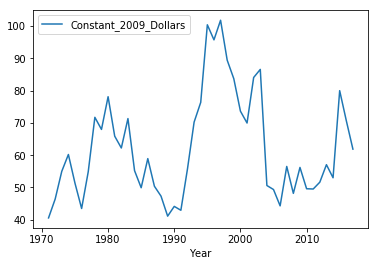

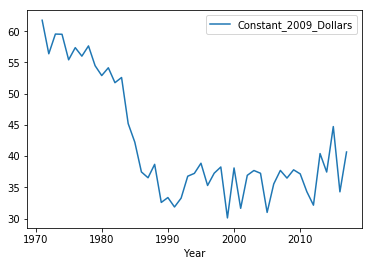

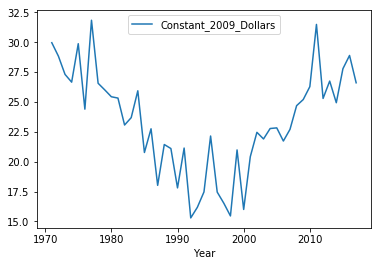

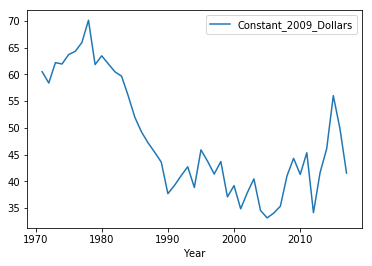

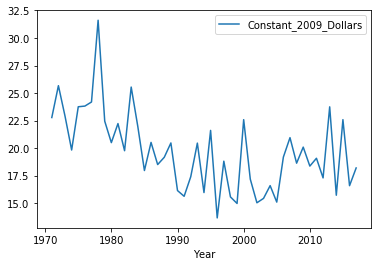

In [126]:

fresh_df.iloc[0:47].plot(y='Constant_2009_Dollars', x= 'Year')
# fresh_df.iloc[47:94].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[94:141].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[141:188].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[188:235].plot(y='Constant_2009_Dollars', x= 'Year')
fresh_df.iloc[235:282].plot(y='Constant_2009_Dollars', x= 'Year')
# fresh_df.iloc[282:302].plot(y='Constant_2009_Dollars', x= 'Year')

# tomatoes, kale 
# tomatoes - prices down, produc down imports up

plt.show()

<a id='4.10'></a>
#### 4.10 Analyze the Market price, production and imports of Tomatoes

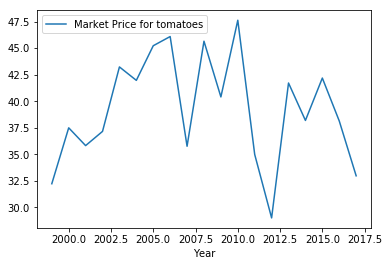

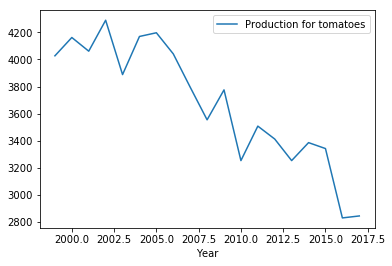

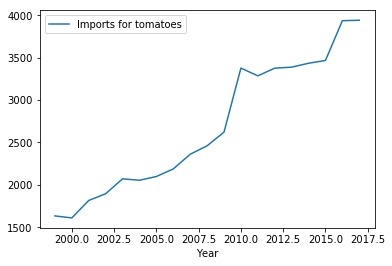

In [127]:

fresh_df.iloc[918:965].plot(y='Constant_2009_Dollars', x= 'Year', label = 'Market Price for tomatoes')
fresh_df.iloc[918:965].plot(y='Production', x= 'Year', label = 'Production for tomatoes')
fresh_df.iloc[918:965].plot(y='Imports', x= 'Year', label = 'Imports for tomatoes')
plt.legend()
plt.show()

Interesting analysis for market prices for vegetables compared to the 1970s level
Tomatoes’ prices going down
Why?
Increasing imports
Impacting production – production also reducing


<a id='4.11'></a>
#### 4.11 Plot the Market prices of vegetables for year

#### 4.11.1 Market price for vegetables

In [128]:
pi_analysis_df = final_df[np.isfinite(final_df['Price_Index'])]

pi_by_year = df1.groupby('Year', as_index=False)['Price_Index'].mean() 
pi_by_year['Year'] = pi_by_year['Year'].astype(int) # convert year to int type
# merge fresh_df and pi_by_year on Year column values
final_df2 = pd.merge(fresh_df, pi_by_year, on="Year")

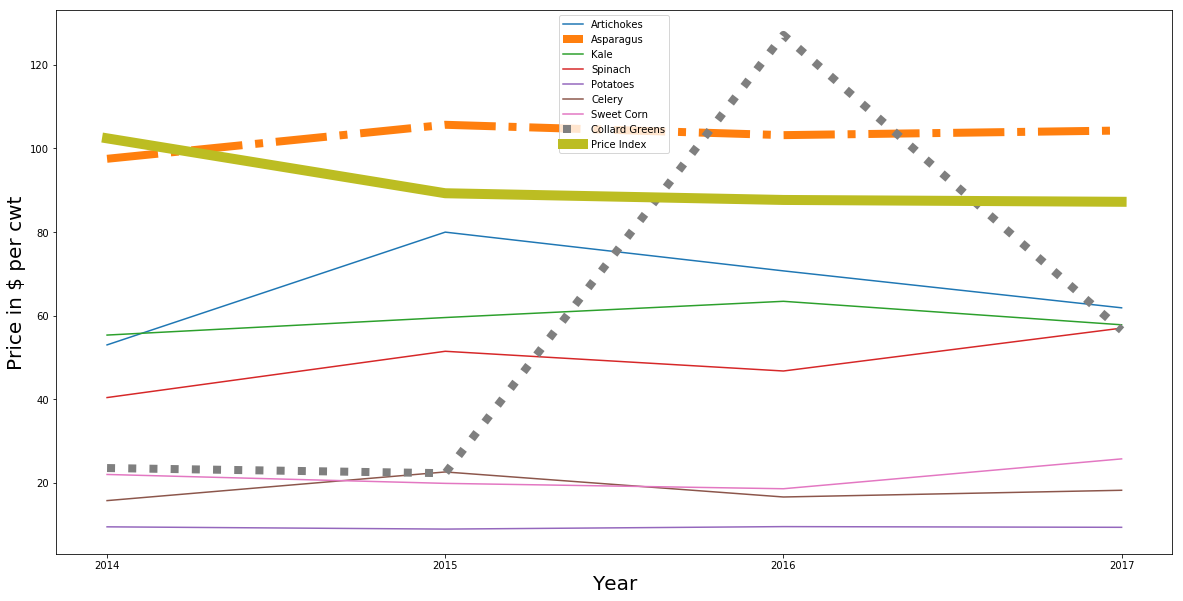

In [129]:
# final_df[:10]
final_df = final_df.replace('            --', 0)
final_df = final_df.replace('             --', 0)
final_df = final_df.replace('--', 0)
# final_df = final_df.fillna(0)
# final_df.iloc[:,1:-1].astype(float)

pmi_data = final_df2.loc[final_df2['Vegetable'].isin(['artichokes'])]
pmi_data2 = final_df2.loc[final_df2['Vegetable'].isin(['asparagus'])]
pmi_data3 = final_df2.loc[final_df2['Vegetable'].isin(['kale'])]
# pmi_data4 = final_df.loc[final_df['Vegetable'].isin(['mustard greens'])]
pmi_data5 = final_df2.loc[final_df2['Vegetable'].isin(['spinach'])]
pmi_data6 = final_df2.loc[final_df2['Vegetable'].isin(['potatoes'])] 
pmi_data7 = final_df2.loc[final_df2['Vegetable'].isin(['celery'])]
pmi_data8 = final_df2.loc[final_df2['Vegetable'].isin(['sweet corn'])]
pmi_data9 = final_df2.loc[final_df2['Vegetable'].isin(['collard greens'])]
pmi_data10 = final_df2.loc[final_df2['Vegetable'].isin(['leaf & romanie lettuce'])]
# df.loc[df['B'].isin(['one','three'])]
plt.figure(figsize=(20,10))
plt.plot(pmi_data['Year'], pmi_data['Constant_2009_Dollars'], label = 'Artichokes')
plt.plot(pmi_data2['Year'], pmi_data2['Constant_2009_Dollars'], label = 'Asparagus', linewidth=8, linestyle="-.")
plt.plot(pmi_data3['Year'], pmi_data3['Constant_2009_Dollars'], label = 'Kale')
# plt.plot(pmi_data4['Year'], pmi_data4['Constant_2009_Dollars'], label = 'Mustard Greens')
plt.plot(pmi_data5['Year'], pmi_data5['Constant_2009_Dollars'], label = 'Spinach')
plt.plot(pmi_data6['Year'], pmi_data6['Constant_2009_Dollars'], label = 'Potatoes')
plt.plot(pmi_data7['Year'], pmi_data7['Constant_2009_Dollars'], label = 'Celery')
plt.plot(pmi_data8['Year'], pmi_data8['Constant_2009_Dollars'], label = 'Sweet Corn')
plt.plot(pmi_data9['Year'], pmi_data9['Constant_2009_Dollars'], label = 'Collard Greens', linewidth=8, linestyle=":")
# plt.plot(pmi_data10['Year'], pmi_data10['Constant_2009_Dollars'], label = 'Lettuce')
plt.plot(pmi_data2['Year'], pmi_data2['Price_Index'],label = 'Price Index', linewidth=10)
plt.legend()
plt.xticks(range(2014,2018))
plt.xlabel('Year', size = 20)
plt.ylabel('Price in $ per cwt', size = 20)
plt.legend()
plt.show()

#### 4.11.2 Deep dive from above plot -Analysis of Asparagus - Why is it consistently costlier
Plot Production to import ratio to see how it varies over years

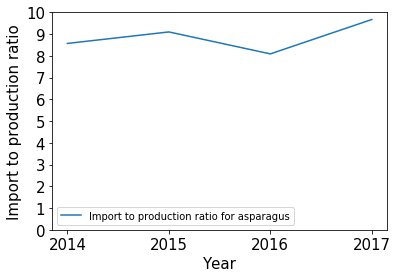

In [130]:
# Plot to show the import to Production ratio of Asparagus
asp_data = pi_analysis_df[pi_analysis_df['Vegetable'] == 'asparagus']
asp_data['Im_Prod_Ratio'] = asp_data['Imports'] / asp_data['Production']
asp_data.plot(y = 'Im_Prod_Ratio', x= 'Year', label = "Import to production ratio for asparagus")
plt.xticks(range(2014,2018), size = 15)
plt.yticks(range(11), size = 15)
plt.ylabel("Import to production ratio", size = 15)
plt.xlabel("Year", size = 15)
# plt.ylabel("Import to production ratio")
plt.show()

In [131]:
final_df = final_df[np.isfinite(final_df['Price_Index'])]
#final_df.set_printoptions(max_rows=500)
# final_df
#.isfinite is used to remove all the Nan values

<a id='4.12'></a>
#### 4.12 Total Imports Per Vegetables

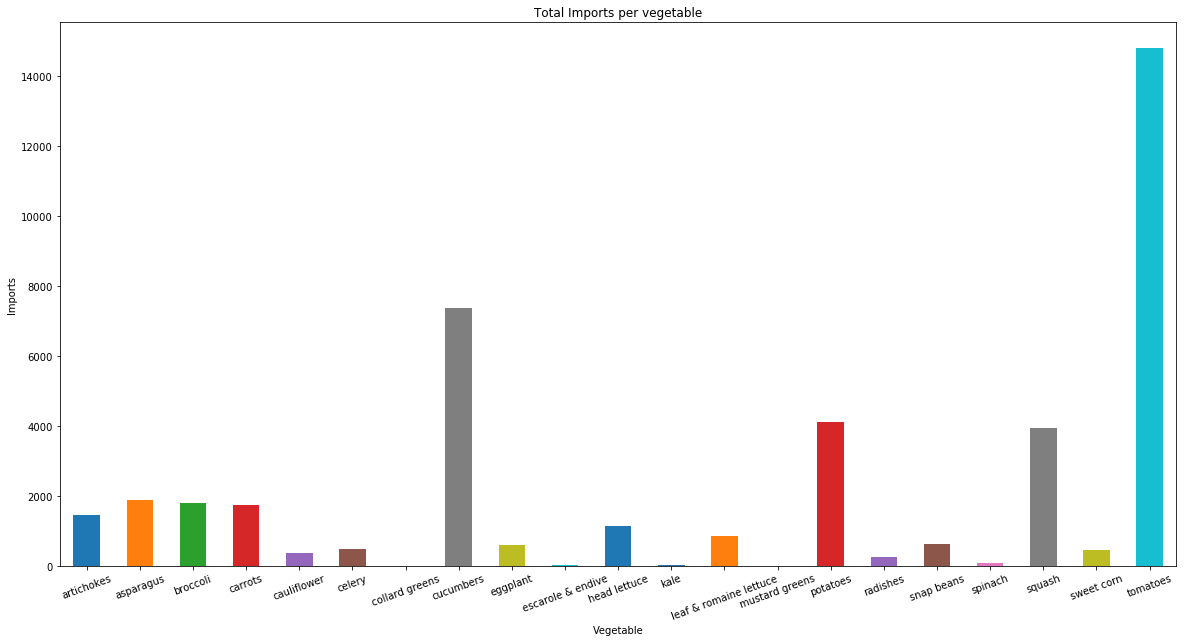

In [132]:
imports = final_df.groupby('Vegetable')['Imports'].sum() 
imports.plot.bar(figsize=(20,10))
plt.title('Total Imports per vegetable')
plt.xticks(rotation=20)
plt.ylabel('Imports')
plt.show()

# Grouping by the vegetable imports
# xticks (rotation = 20), rotates the text 20 degrees

<a id='4.13'></a>
#### 4.13 Plot the Price Index on Total Imports per Vegetable 

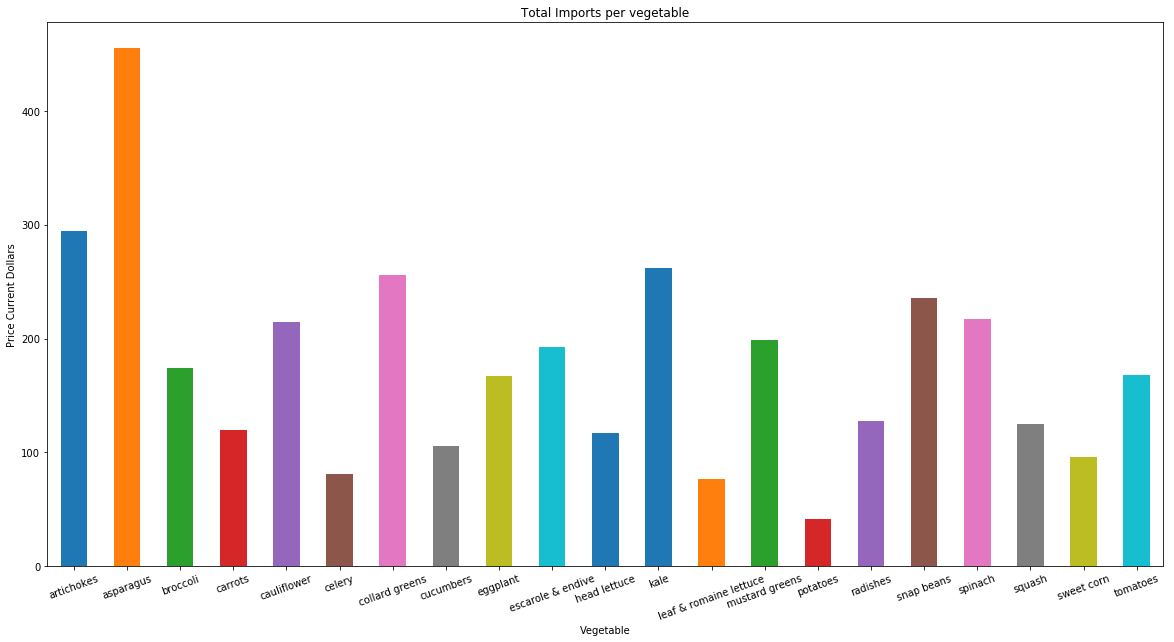

In [133]:
price = final_df.groupby('Vegetable')['Current_Dollars'].sum() 
price.plot.bar(figsize=(20,10))
plt.title('Total Imports per vegetable')
plt.xticks(rotation=20)
plt.ylabel('Price Current Dollars')
plt.show()

#Grouping by the vegetable imports
# xticks (rotation = 20), rotates the text 20 degrees 

<a id='4.14'></a>
##### 4.14 Plot the Price Index of Vegetables when production is greter than Imports

In [134]:
pd.options.mode.chained_assignment = None
#The above statement is used to deal with the below warning
#SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
final_df['prod_imp'] = final_df.eval('Production>Imports')
#Creating a new dataframe by evaluating if Production>imports
#The idea is to display the current dollars for vegetables where the production is greater than the imports

In [135]:
Product_greater_imports_true = final_df.loc[final_df['prod_imp']== True]

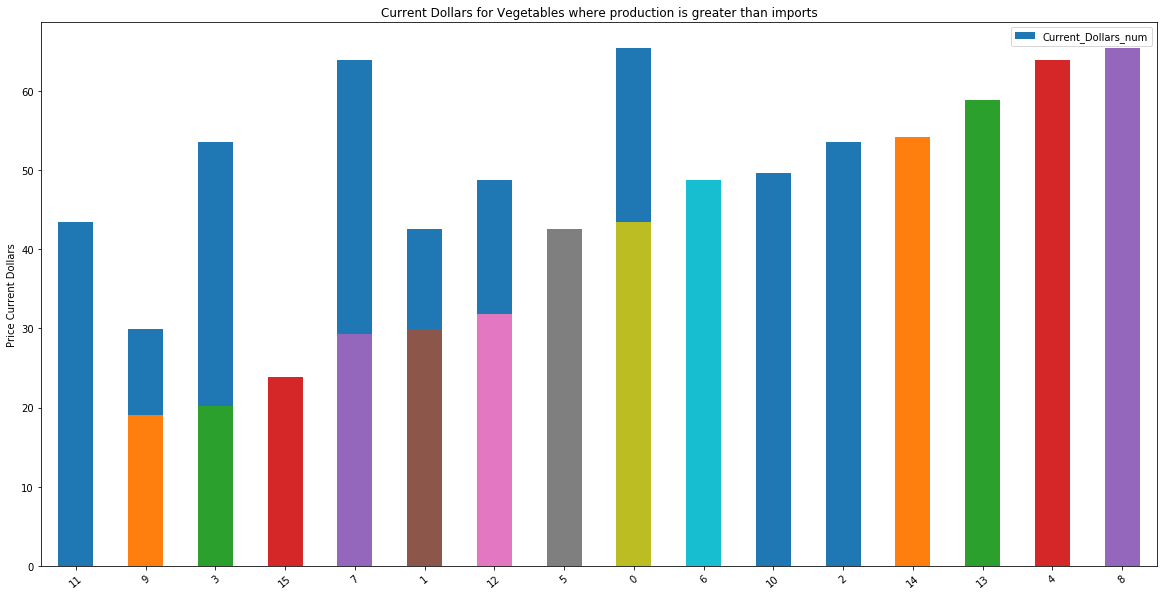

In [136]:
#Product_greater_imports_true['Price_Index'] 
pd.options.mode.chained_assignment = None
Product_greater_imports_true['Current_Dollars_num'] = pd.to_numeric(Product_greater_imports_true['Current_Dollars'])
# using pd.to_numeric to change the type of Current_Dollars from Object to number
Product_greater_imports_true_plot = Product_greater_imports_true.groupby(['Vegetable'], as_index = False)['Current_Dollars_num'].mean()
# grouping by the vegetable Current_dollars and taking the mean of the data 
Product_greater_imports_true_plot.plot.bar(figsize=(20,10))
Product_greater_imports_true_plot.sort_values('Current_Dollars_num', ascending=True)['Current_Dollars_num'].plot.bar(x=Product_greater_imports_true_plot['Vegetable'], stacked=True)
plt.title('Current Dollars for Vegetables where production is greater than imports')
plt.xticks(rotation=40)
plt.ylabel('Price Current Dollars')
plt.show()

<a id='4.15'></a>
#### 4.15 Plot the Price Index of Vegetables when Protein content is greter than Sugars

In [137]:
final_df['protein_sugars_ratio'] = final_df['Protein'] / final_df['Sugars']
#final_df['protein_sugars_ratio']
#The idea is to display the vegetable dataframe where the ratio of protein content is greater than the sugars

In [138]:
ratio_greater_protein_current = final_df.loc[final_df['protein_sugars_ratio']> 1]
#getting the vegeatables whose protein content is greater than sugars

In [139]:
pd.options.mode.chained_assignment = None
ratio_greater_protein_current['Current_Dollars_num'] = pd.to_numeric(ratio_greater_protein_current['Current_Dollars'])
# using pd.to_numeric to change the type of Current_Dollars from Object to number

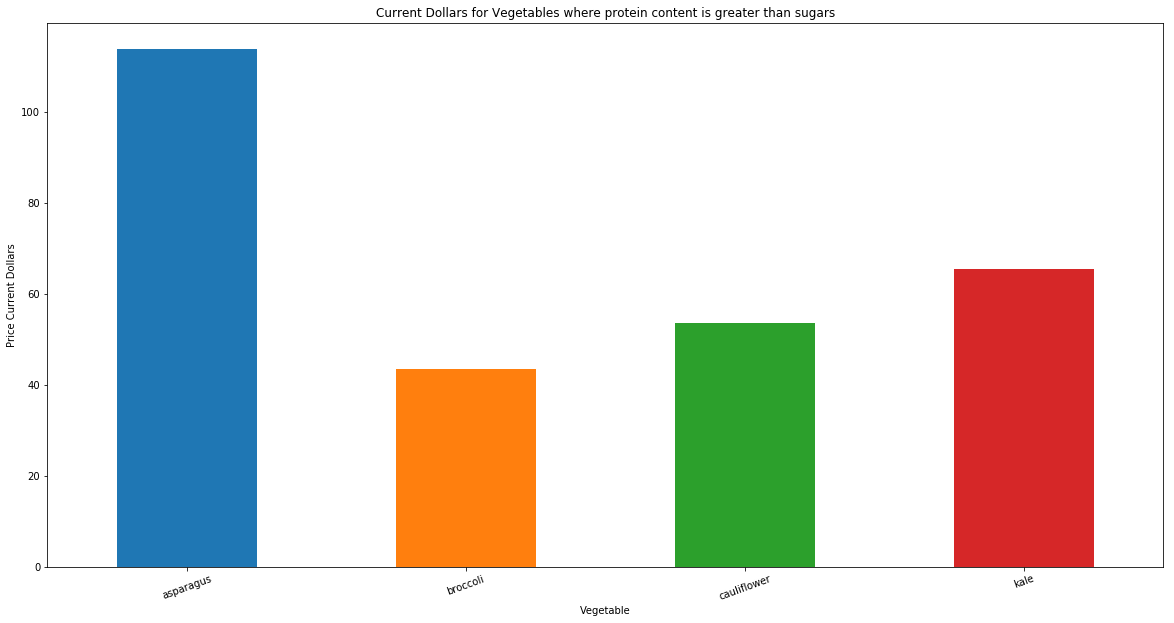

In [140]:
Price_vegetable_greater_protein = ratio_greater_protein_current.groupby(['Vegetable'])['Current_Dollars_num'].mean()
#grouping by the vegetable Current_dollars and taking the mean of the data 
Price_vegetable_greater_protein.plot.bar(figsize=(20,10))
plt.title('Current Dollars for Vegetables where protein content is greater than sugars')
plt.xticks(rotation=20)
plt.ylabel('Price Current Dollars')
plt.show()

In [141]:
final_df['Current_Dollars_num'] = pd.to_numeric(final_df['Current_Dollars'])
#final_df

In [142]:
pd.options.mode.chained_assignment = None
Product_greater_imports_true['Current_Dollars_num'] = pd.to_numeric(Product_greater_imports_true['Current_Dollars'])

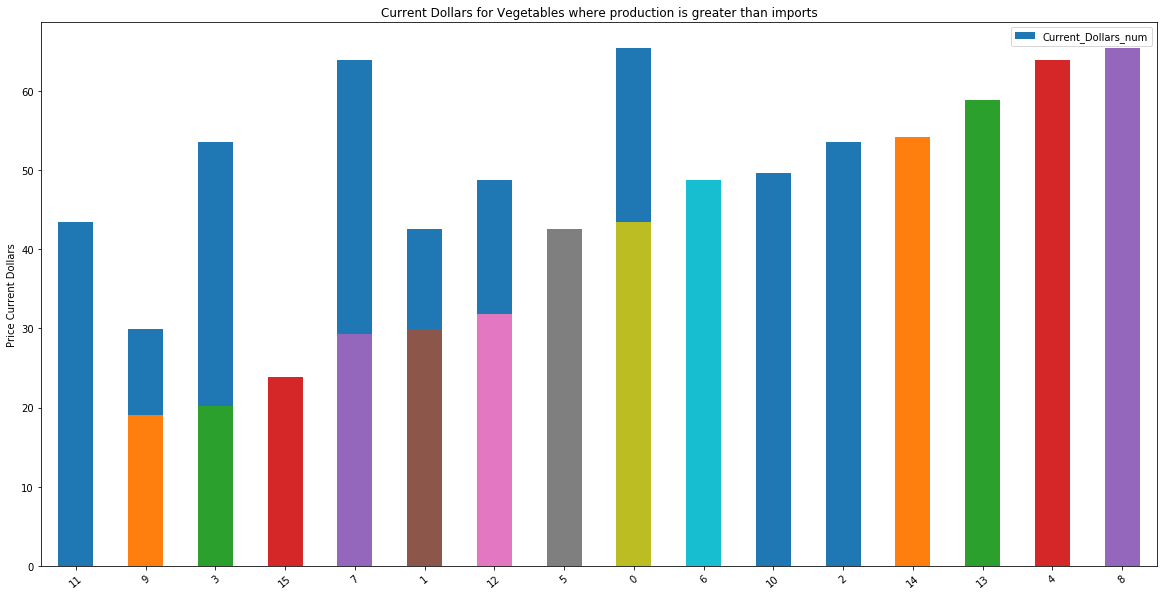

In [143]:
Product_greater_imports_true_plot = Product_greater_imports_true.groupby(['Vegetable'], as_index = False)['Current_Dollars_num'].mean()
#grouping by the vegetable Current_dollars and taking the mean of the data 
Product_greater_imports_true_plot.plot.bar(figsize=(20,10))
Product_greater_imports_true_plot.sort_values('Current_Dollars_num', ascending=True)['Current_Dollars_num'].plot.bar(x=Product_greater_imports_true_plot['Vegetable'], stacked=True)
plt.title('Current Dollars for Vegetables where production is greater than imports')
plt.xticks(rotation=40)
plt.ylabel('Price Current Dollars')
plt.show()